In [1]:
import json
import functools
import multiprocessing
from pathlib import Path

import numpy as np
import numpy.linalg
import pandas as pd
import scipy as sp
import scipy.optimize
from matplotlib import pyplot as plt

from helper import get_station_data, get_train_test_time_ranges

In [2]:
province='AB'
#province='BC'
# province='MB'
#province='NB'
#province='NL'
#province='NS'
#province='NT'
#province='NU'
# province='ON'
#province='PE'
#province='QC'
#province='SK'
#province='YT'

# station_id_set = set(['6158355', '6158359'])
station_id_set = set(['3034479', '3034485'])

In [3]:
raw_data_base_dir = Path('raw-data')

In [4]:
df = get_station_data(
    raw_data_base_dir / province,
    station_id_set=station_id_set,
)

In [5]:
len(df)

311253

In [6]:
group = df.groupby('Climate ID')
display(group.count().rsub(group.size(), axis=0))

,Longitude (x),Latitude (y),Station Name,Date/Time (LST),Year,Month,Day,Time (LST),Wind Dir (10s deg),Wind Spd (km/h)
Climate ID,,,,,,,,,,
3034479,0,0,0,0,0,0,0,0,9405,1289
3034485,0,0,0,0,0,0,0,0,9609,915


In [7]:
df

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time (LST),Year,Month,Day,Time (LST),Wind Dir (10s deg),Wind Spd (km/h)
0,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 15:00:00,2001,1,12,15:00,2.0,13.0
1,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 16:00:00,2001,1,12,16:00,1.0,11.0
2,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 17:00:00,2001,1,12,17:00,2.0,9.0
3,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 18:00:00,2001,1,12,18:00,2.0,9.0
4,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 19:00:00,2001,1,12,19:00,3.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...
311248,-110.72,50.03,MEDICINE HAT RCS,3034485,2023-08-18 21:00:00,2023,8,18,21:00,34.0,19.0
311249,-110.72,50.02,MEDICINE HAT,3034479,2023-08-18 22:00:00,2023,8,18,22:00,29.0,18.0
311250,-110.72,50.03,MEDICINE HAT RCS,3034485,2023-08-18 22:00:00,2023,8,18,22:00,31.0,15.0
311251,-110.72,50.02,MEDICINE HAT,3034479,2023-08-18 23:00:00,2023,8,18,23:00,29.0,26.0


In [8]:
direction_mask = (
    (~df['Wind Spd (km/h)'].isna())
    *
    (~df['Wind Dir (10s deg)'].isna())
    *
    (df['Wind Dir (10s deg)'] > (degree_tol := 0.1))
)

In [9]:
deca_degree_to_rad = 10 * np.pi / 180

for deca_degree in [0, 9, 18, 27, 36]:
    print(f'{deca_degree=}')
    print('N/S: {}'.format(np.cos(deca_degree * deca_degree_to_rad)))
    print('E/W: {}'.format(np.sin(deca_degree * deca_degree_to_rad)))
    print()

deca_degree=0
N/S: 1.0
E/W: 0.0

deca_degree=9
N/S: 6.123233995736766e-17
E/W: 1.0

deca_degree=18
N/S: -1.0
E/W: 1.2246467991473532e-16

deca_degree=27
N/S: -1.8369701987210297e-16
E/W: -1.0

deca_degree=36
N/S: 1.0
E/W: -2.4492935982947064e-16



In [10]:
df.loc[direction_mask, 'Wind Spd N/S'] = (
    df.loc[direction_mask, 'Wind Spd (km/h)']
    *
    np.cos(
        df.loc[direction_mask, 'Wind Dir (10s deg)'] * deca_degree_to_rad
    )
)
df.loc[direction_mask, 'Wind Spd E/W'] = (
    df.loc[direction_mask, 'Wind Spd (km/h)']
    *
    np.sin(
        df.loc[direction_mask, 'Wind Dir (10s deg)'] * deca_degree_to_rad
    )
)

df.loc[~direction_mask, ['Wind Spd N/S', 'Wind Spd E/W']] = np.nan

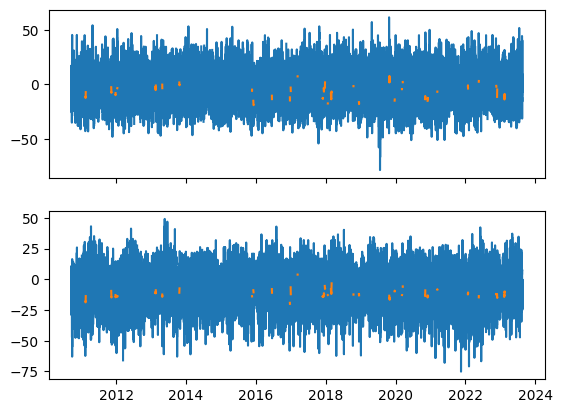

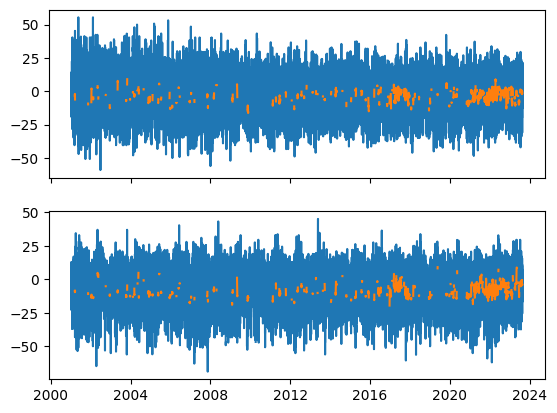

In [11]:
roll_window = 24*7

for index, sub_df in df.groupby('Climate ID'):
    fig, (ax_i1, ax_i2) = plt.subplots(nrows=2, sharex=True)
    ax_i1.plot(
        sub_df['Date/Time (LST)'],
        sub_df['Wind Spd N/S'],
        label='Moving Average',
    )
    ax_i1.plot(
        sub_df['Date/Time (LST)'],
        sub_df['Wind Spd N/S'].rolling(roll_window).mean(),
        label='Moving Average',
    )
    ax_i2.plot(
        sub_df['Date/Time (LST)'],
        sub_df['Wind Spd E/W'],
        label='Moving Average',
    )
    ax_i2.plot(
        sub_df['Date/Time (LST)'],
        sub_df['Wind Spd E/W'].rolling(roll_window).mean(),
        label='Moving Average',
    )
plt.show()

In [12]:
df

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time (LST),Year,Month,Day,Time (LST),Wind Dir (10s deg),Wind Spd (km/h),Wind Spd N/S,Wind Spd E/W
0,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 15:00:00,2001,1,12,15:00,2.0,13.0,12.216004,4.446262
1,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 16:00:00,2001,1,12,16:00,1.0,11.0,10.832885,1.910130
2,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 17:00:00,2001,1,12,17:00,2.0,9.0,8.457234,3.078181
3,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 18:00:00,2001,1,12,18:00,2.0,9.0,8.457234,3.078181
4,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 19:00:00,2001,1,12,19:00,3.0,11.0,9.526279,5.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
311248,-110.72,50.03,MEDICINE HAT RCS,3034485,2023-08-18 21:00:00,2023,8,18,21:00,34.0,19.0,17.854160,-6.498383
311249,-110.72,50.02,MEDICINE HAT,3034479,2023-08-18 22:00:00,2023,8,18,22:00,29.0,18.0,6.156363,-16.914467
311250,-110.72,50.03,MEDICINE HAT RCS,3034485,2023-08-18 22:00:00,2023,8,18,22:00,31.0,15.0,9.641814,-11.490667
311251,-110.72,50.02,MEDICINE HAT,3034479,2023-08-18 23:00:00,2023,8,18,23:00,29.0,26.0,8.892524,-24.432008


In [13]:
ts_dfs = []
for index, sub_df in df.groupby(by='Climate ID'):
    ts_df = sub_df[['Date/Time (LST)', 'Wind Spd N/S', 'Wind Spd E/W']]
    ts_df = (
        ts_df
        .set_index('Date/Time (LST)')
        .rename(
            columns={
                colname: f'{index} - {colname}'
                for colname in ts_df.columns
            },
        )
    )
    ts_dfs.append(ts_df)

ts_df = pd.concat(ts_dfs, ignore_index=False, axis='columns')
display(ts_df)

,3034479 - Wind Spd N/S,3034479 - Wind Spd E/W,3034485 - Wind Spd N/S,3034485 - Wind Spd E/W
Date/Time (LST),,,,
2001-01-12 15:00:00,NaN,NaN,12.216004,4.446262
2001-01-12 16:00:00,NaN,NaN,10.832885,1.910130
2001-01-12 17:00:00,NaN,NaN,8.457234,3.078181
2001-01-12 18:00:00,NaN,NaN,8.457234,3.078181
2001-01-12 19:00:00,NaN,NaN,9.526279,5.500000
...,...,...,...,...
2023-08-18 19:00:00,38.527397,-14.022826,21.665771,-3.820260
2023-08-18 20:00:00,25.980762,-15.000000,19.733545,-7.182423
2023-08-18 21:00:00,36.648012,-13.338786,17.854160,-6.498383


In [15]:
def score_vec(item, matrix):
    try:
        (curr_idx, curr_row), (next_idx, next_row) = item
    except:
        return

    if curr_row.isna().any() or next_row.isna().any():
        return None
    
    x_curr = curr_row.iloc[:]
    x_next = next_row.iloc[:]

    x_pred = matrix @ x_curr

    delta = x_next - x_pred

    return np.linalg.norm(delta)**2

def objective_func(xx, train_df, num_workers=None):
    num_elements = xx.size
    side = int(np.sqrt(num_elements))
    matrix = xx.reshape(side,side)
    
    iterators = [
        train_df.iterrows(),
        train_df.iterrows(),
    ]
    
    # move the second one forward
    next(iterators[1])

    score = 0
    with multiprocessing.Pool(processes=num_workers) as pool:
        for result in pool.imap_unordered(
            func=functools.partial(
                score_vec,
                matrix=matrix,
            ),
            iterable=zip(*iterators),
            chunksize=256,
        ):
            if result is None:
                continue

            score += result

    return score

In [ ]:
results = []
for idx,(train_range, test_range) in enumerate(get_train_test_time_ranges()):
    train_start, train_end = train_range
    test_start, test_range = train_range

    train_mask = ts_df.index.map(lambda time_idx: time_idx >= train_start and time_idx <= train_end)
    test_mask = ts_df.index.map(lambda time_idx: time_idx >= test_start and time_idx <= test_range)

    train_df = ts_df[train_mask]
    test_df = ts_df[test_mask]

    display(train_df.count().rsub(train_df.size, axis=0))

    result = sp.optimize.minimize(
        fun=functools.partial(
            objective_func,
            train_df=train_df,
        ),
        x0=np.eye(4).flatten() if len(results) == 0 else results[-1].x,
    )
    print(result)
    with open(f'time-series-with-direction-{idx}.json', 'w') as flink:
        json.dump(list(result.x), flink)
    results.append(result)


3034479 - Wind Spd N/S    81436
3034479 - Wind Spd E/W    81436
3034485 - Wind Spd N/S    80090
3034485 - Wind Spd E/W    80090
dtype: int64

In [ ]:
for (train_range, test_range), result in zip(test_train_ranges,results):
    train_start, train_end = train_range
    test_start, test_end = test_range

    train_mask = ts_df.index.map(lambda time_idx: time_idx >= train_start and time_idx <= train_end)
    test_mask = ts_df.index.map(lambda time_idx: time_idx >= test_start and time_idx <= test_end)

    train_df = ts_df[train_mask]
    test_df = ts_df[test_mask]


    test_score = objective_func(result.x, train_df=test_df)
    train_rsm = np.sqrt(result.fun / len(train_df))
    test_rms = np.sqrt(test_score/len(test_df))

    display(result)
    print(f'{train_rsm=}')
    print(f'{test_score=}')
    print(f'{test_rms=}')
    print()
